In [3]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from math import *

F_geo = lambda x,p: np.floor(np.log(1-x)/np.log(1-p))
f = lambda x,p: p* (1-p)**(x-1)
Trans = lambda x: 10**(-0.2*x/10)
def h(p_list):
    y_list = np.zeros(len(p_list))
    for i,p in enumerate(p_list):
        if p<1e-6 or (1-p)<1e-6:
            y_list[i]= 0
        else:
            y_list[i]= -p*np.log2(p)-(1-p)*np.log2(1-p)
    return y_list

# One repeater

# Parallel
## Rate vs. Distance

In [4]:
def T_avg_one_repeater(L1,L2,Nmax=10000):
    """ calculates the performance of parallel scheme with one repeater
        no cut-off
        L1,L2: elementary link lengths
        Nmax: ensemble size for averaging
    """
    τ1 = L1/c
    τ2 = L2/c
    p1 = p_link*Trans(L1)
    p2 = p_link*Trans(L2)
    N1 = F_geo(np.random.uniform(low=p1, high=1, size=(Nmax,)),p1)
    N2 = F_geo(np.random.uniform(low=p2, high=1, size=(Nmax,)),p2)
    Ts = np.max(np.array([(2*N1-1)*τ1,2*N2*τ2]),axis=0)
    T_tot = τ1 + np.mean(Ts)
    f_memory = np.mean(np.exp(-(4*Ts-(4*N1-5)*τ1-(4*N2-3)*τ2)/τ_coh))
    f_memory_qkd = np.mean(np.exp(-(2*Ts-(2*N1-1)*τ1-(2*N2-2)*τ2)/τ_coh))
    return T_tot, f_memory, f_memory_qkd

def T_avg_par_one_repeater(L1,L2,τ_cut,Nmax=100000):
    """ calculates the performance of parallel scheme with one repeater
        τ_cut: cut-off time
        L1,L2: elementary link lengths
        *** only valid for L1=L2 ****
        Nmax: ensemble size for averaging
    """
    τ1 = L1/c
    τ2 = L2/c
    p1 = p_link*Trans(L1)
    p2 = p_link*Trans(L2)
    N1 = F_geo(np.random.uniform(low=p1, high=1, size=(Nmax,)),p1)
    N2 = F_geo(np.random.uniform(low=p2, high=1, size=(Nmax,)),p2)
    Ts = np.max(np.array([(2*N1-1)*τ1,2*N2*τ2]),axis=0) # swap moment
    inds1 = np.argwhere( Ts-(2*N1-1)*τ1 <= τ_cut )[:,0]
    inds2 = np.argwhere( Ts-2*(N2-1)*τ2 <= τ_cut )[:,0]
    succ_inds = np.intersect1d(inds1,inds2)
    T_succ = np.sum(Ts[succ_inds]+ τ1) 
    T_fail = (2*τ1/p1 + τ_cut)*(Nmax-len(succ_inds))
    T_tot = (T_succ+T_fail)/len(succ_inds)

# skr will be added later.
#     f_memory = np.mean(np.exp(-(4*Ts-(4*N1-5)*τ1-(4*N2-3)*τ2)/τ_coh))
#     f_memory_qkd = np.mean(np.exp(-(2*Ts-(2*N1-1)*τ1-(2*N2-2)*τ2)/τ_coh))
    return T_tot #, f_memory, f_memory_qkd


In [6]:
c = 2e5 # speed of light [km/s]
τ_coh = 0.01
p_link= 1
τ_cut = 0.5*τ_coh # cutoff

L0_list = np.linspace(10,200,41) # e2e distance [km]
inv_rate_par = np.zeros(len(L0_list))
# f_memory_qkd_seq = np.zeros(len(L0_list))
inv_rate_par_cutoff = np.zeros(len(L0_list))
# f_memory_qkd_seq_cutoff = np.zeros(len(L0_list))

# inv_rate_seq_cutoff_realtime = np.zeros(len(L0_list))
# f_memory_qkd_seq_cutoff_realtime = np.zeros(len(L0_list))

for i, L0 in enumerate(L0_list):
    L1 = L0/2
    L2 = L0/2
#     f_memory_qkd_seq[i] = p_link*Trans(L2)*np.exp(-4*L2/(c*τ_coh))/(1- (1-p_link*Trans(L2))*np.exp(-2*L2/(c*τ_coh)) )
    p1 = p_link*Trans(L1)
    q1= 1-p1 
    inv_rate_par[i], _, _ = T_avg_one_repeater(L1,L2)
#     f_memory_qkd_seq_cutoff[i] = p1*np.exp(-4*τ1/τ_coh)*(1- (q1*np.exp(-2*τ1/τ_coh))**m )/(1- q1*np.exp(-2*τ1/τ_coh) )/(1- q1**m)
    inv_rate_par_cutoff[i] = T_avg_par_one_repeater(L1,L2,τ_cut)
    

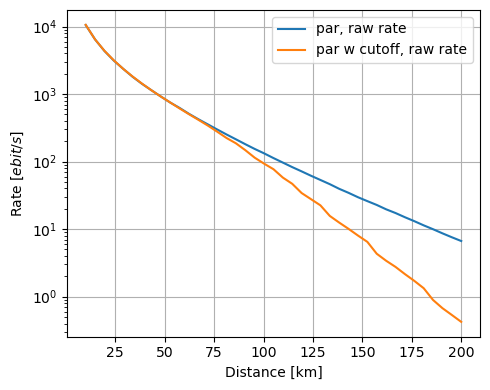

In [7]:
# f_qkd_seq = 0.5-0.5*f_memory_qkd_seq
# f_qkd_seq_cutoff = 0.5-0.5*f_memory_qkd_seq_cutoff
plt.figure(figsize=(5,4))
# plt.plot(L0_list,-np.log2(1-Trans(L0_list)),"k--", label="PLOB")
plt.plot(L0_list,1/inv_rate_par,"-",color="C0", label="par, raw rate")
plt.plot(L0_list,1/inv_rate_par_cutoff,"-",color="C1", label="par w cutoff, raw rate")
# plt.plot(L0_list,1/inv_rate_seq_cutoff_realtime,".",color="C2", label="RT, seq w cutoff, raw rate")
plt.yscale("log")
plt.xlabel("Distance [km]")
plt.ylabel(r"Rate $[ebit/s]$")
# plt.ylim([1e-4,1e5])
plt.grid()
plt.legend()
plt.tight_layout()
# plt.savefig("figures_realtime/one_repeater_no_cutoff.pdf")
plt.show()

## Rate vs. cutoff time

In [24]:
c = 2e5 # speed of light [km/s]
τ_coh = 0.1 # coherence time [sec]
p_link= 1
τ_cut_list = np.linspace(0.01,0.5)*τ_coh # cutoff [sec]
L0 = 150 # e2e distance [km]

inv_rate_par, _, _ = T_avg_one_repeater(L0/2,L0/2)

inv_rate_par_cutoff = np.zeros(len(τ_cut_list))
for i_t, τ_cut in enumerate(τ_cut_list):
    L1 = L0/2
    L2 = L0/2
    inv_rate_par_cutoff[i_t] = T_avg_par_one_repeater(L1,L2,τ_cut)


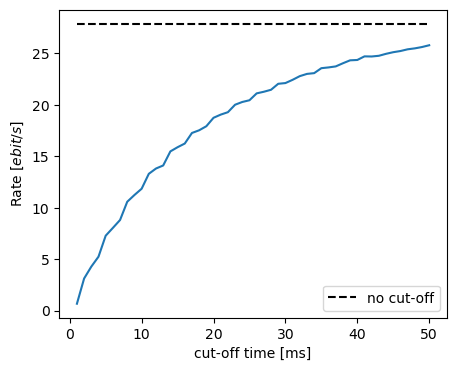

In [25]:
plt.figure(figsize=(5,4))
plt.plot(τ_cut_list*1e3,1/inv_rate_par_cutoff,"-")
plt.plot(τ_cut_list*1e3,1/inv_rate_par+0*τ_cut_list,"k--",label="no cut-off")

plt.ylabel(r"Rate $[ebit/s]$")
plt.xlabel("cut-off time [ms]")
plt.legend()
plt.show()
